In [33]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from matplotlib.animation import ArtistAnimation, FuncAnimation
from tqdm import tqdm

from datasets import CubeObstacle, CylinderObstacle
from utils.config import Hyperparameters as hparams
from utils.tools import calc_sig_strength, calc_sig_strength_gpu, calc_loss

np.random.seed(42)
logging.basicConfig(level=logging.INFO)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [34]:
# Create Obstacle

obstacle_ls = [
    CubeObstacle(-30, 15, 35, 60, 20, 0.3),
    CubeObstacle(-30, -25, 45, 10, 35, 0.3),
    CylinderObstacle(0, -30, 70, 10, 0.3)
]


In [35]:
gnd_nodes = np.array([[-5, -5, 0],
                      [-5, 5, 0],
                      [5, -5, 0],
                      [5                        , 5, 0]], dtype=np.float32)
gnd_nodes

array([[-5., -5.,  0.],
       [-5.,  5.,  0.],
       [ 5., -5.,  0.],
       [ 5.,  5.,  0.]], dtype=float32)

INFO:root:Obstacle.points.shape: (3, 2040)
INFO:root:Obstacle.points.shape: (3, 1319)
INFO:root:Obstacle.points.shape: (3, 1413)
INFO:root:gnd_nodes: [[-5. -5.  0.]
 [-5.  5.  0.]
 [ 5. -5.  0.]
 [ 5.  5.  0.]]


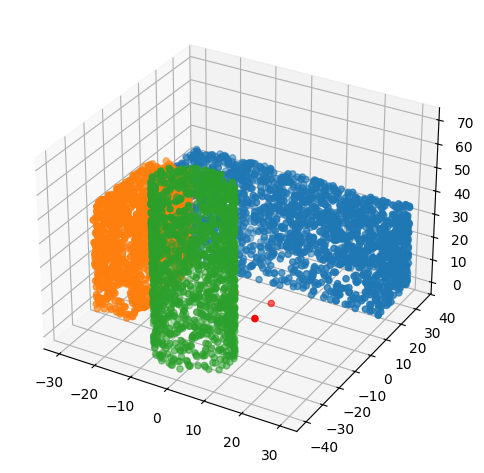

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for obstacle in obstacle_ls:
    obstacle.plot(ax)
    logging.info(f"Obstacle.points.shape: {obstacle.points.shape}")

gnd_nodes = np.array(gnd_nodes)
logging.info(f"gnd_nodes: {gnd_nodes}")
ax.scatter(gnd_nodes[:, 0], gnd_nodes[:, 1], gnd_nodes[:, 2], c='r')
fig.tight_layout()
plt.show()

In [37]:
X, Y = np.meshgrid(
    np.arange(-hparams.area_size // 2, hparams.area_size // 2),
    np.arange(-hparams.area_size // 2, hparams.area_size // 2),
    indexing='xy'
)
Z = np.full_like(X, 70)

station_positions = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)

In [38]:
sig = np.array([calc_sig_strength(station_pos, gnd_nodes, obstacle_ls) for station_pos in tqdm(station_positions)])
sig = sig.reshape(hparams.area_size, hparams.area_size)

max_idx = np.unravel_index(np.argmax(sig), sig.shape)
logging.info(f"Max Signal: {sig[max_idx]}, Index: {max_idx}")

100%|██████████| 40000/40000 [00:28<00:00, 1403.16it/s]
INFO:root:Max Signal: 15899.721755455808, Index: (np.int64(99), np.int64(100))


In [39]:
t_station = torch.tensor(station_positions, dtype=torch.float32).to(device)
t_gnd_nodes = torch.tensor(gnd_nodes, dtype=torch.float32).to(device)
obst_points = []
for obstacle in obstacle_ls:
    obst_points.append(torch.tensor(obstacle.points, dtype=torch.float32))
t_obst_points = torch.cat([op for op in obst_points], dim=1).mT.to(device)
sig = calc_sig_strength_gpu(t_station, t_gnd_nodes, t_obst_points)
sig = sig.reshape(hparams.area_size, hparams.area_size).cpu()

max_idx = np.unravel_index(torch.argmax(sig), sig.shape)
logging.info(f"Max Signal: {sig[max_idx]}, Index: {max_idx}")

/var/folders/mh/6mk8rhdd0t72bpg14f84plrw0000gn/T/ipykernel_39616/2026878922.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  max_idx = np.unravel_index(torch.argmax(sig), sig.shape)
INFO:root:Max Signal: 13.956620216369629, Index: (np.int64(99), np.int64(100))


In [40]:
sig = np.array([calc_loss(station_pos.unsqueeze(0), t_gnd_nodes.unsqueeze(0), t_obst_points).cpu() for station_pos in tqdm(t_station)])
sig = sig.reshape(hparams.area_size, hparams.area_size)

min_idx = np.unravel_index(np.argmin(sig), sig.shape)
logging.info(f"Min Loss: {sig[min_idx]}, Index: {min_idx}")


100%|██████████| 40000/40000 [00:57<00:00, 691.13it/s]
INFO:root:Min Loss: -13.956621170043945, Index: (np.int64(99), np.int64(100))


INFO:root:Obstacle.points.shape: (3, 2040)
INFO:root:Obstacle.points.shape: (3, 1319)
INFO:root:Obstacle.points.shape: (3, 1413)
INFO:root:0, -1
INFO:root:gnd_nodes: [[-5. -5.  0.]
 [-5.  5.  0.]
 [ 5. -5.  0.]
 [ 5.  5.  0.]]


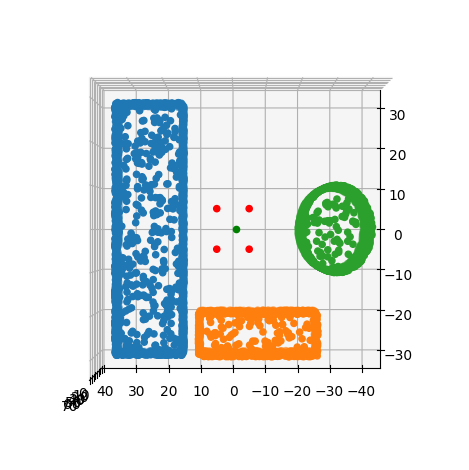

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90, azim=180)
for obstacle in obstacle_ls:
    obstacle.plot(ax)
    logging.info(f"Obstacle.points.shape: {obstacle.points.shape}")
    
logging.info(f"{min_idx[1]-100}, {min_idx[0]-100}")

gnd_nodes = np.array(gnd_nodes)
logging.info(f"gnd_nodes: {gnd_nodes}")
ax.scatter(gnd_nodes[:, 0], gnd_nodes[:, 1], gnd_nodes[:, 2], c='r')
ax.scatter([min_idx[1]-100], [min_idx[0]-100], [70], c='g')
fig.tight_layout()
plt.show()